In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [3]:
import torch
print(torch.__version__)
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")
if torch.cuda.is_available():
    print(f"CUDA is available. GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. PyTorch cannot detect the GPU.")


2.5.1+cu121
NVIDIA GeForce RTX 4050 Laptop GPU
CUDA is available. GPU: NVIDIA GeForce RTX 4050 Laptop GPU


In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [5]:
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [6]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    return running_loss / len(loader.dataset)

def evaluate(model, loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    accuracy = 100 * correct / total
    return running_loss / len(loader.dataset), accuracy

### SGD with Momentum

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet18(num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# Define a learning rate scheduler to decay the learning rate
# Here, we reduce the learning rate by 0.1 every 10 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training the Model
num_epochs = 20
train_losses_sgd, test_losses_sgd, test_accuracies_sgd = [], [], []

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
    
    # Adjust learning rate with the scheduler
    scheduler.step()
    
    train_losses_sgd.append(train_loss)
    test_losses_sgd.append(test_loss)
    test_accuracies_sgd.append(test_accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Epoch [1/20], Train Loss: 2.1531, Test Loss: 1.6585, Test Accuracy: 37.98%
Epoch [2/20], Train Loss: 1.5429, Test Loss: 1.4378, Test Accuracy: 47.08%
Epoch [3/20], Train Loss: 1.2897, Test Loss: 1.1649, Test Accuracy: 58.53%
Epoch [4/20], Train Loss: 1.0656, Test Loss: 1.0030, Test Accuracy: 64.61%
Epoch [5/20], Train Loss: 0.8977, Test Loss: 1.0141, Test Accuracy: 65.31%
Epoch [6/20], Train Loss: 0.7825, Test Loss: 1.0943, Test Accuracy: 64.20%
Epoch [7/20], Train Loss: 0.6748, Test Loss: 0.7407, Test Accuracy: 73.91%
Epoch [8/20], Train Loss: 0.6139, Test Loss: 0.8481, Test Accuracy: 71.46%
Epoch [9/20], Train Loss: 0.5660, Test Loss: 0.6151, Test Accuracy: 79.00%
Epoch [10/20], Train Loss: 0.5377, Test Loss: 0.6771, Test Accuracy: 76.68%
Epoch [11/20], Train Loss: 0.3633, Test Loss: 0.3731, Test Accuracy: 87.04%
Epoch [12/20], Train Loss: 0.3057, Test Loss: 0.3596, Test Accuracy: 87.47%
Epoch [13/20], Train Loss: 0.2842, Test Loss: 0.3520, Test Accuracy: 88.04%
Epoch [14/20], Train 

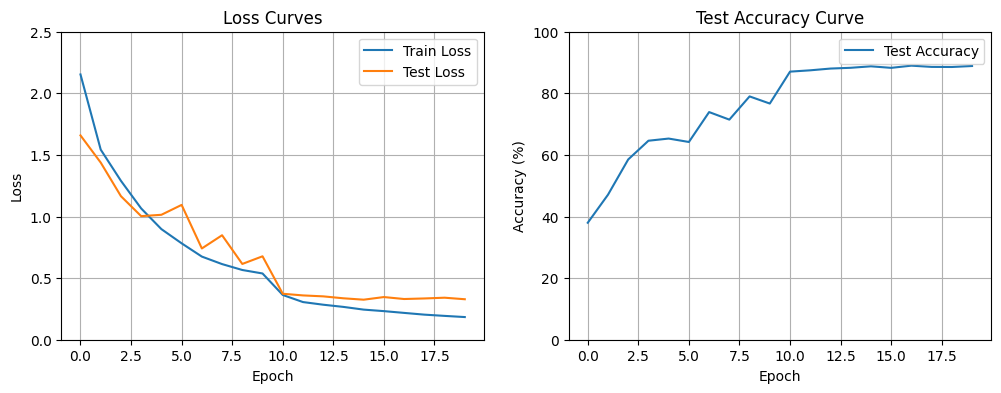

In [9]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses_sgd, label='Train Loss')
plt.plot(test_losses_sgd, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,2.5)
plt.grid(True)
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(test_accuracies_sgd, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.ylim(0,100)
plt.grid(True)
plt.legend()
plt.title('Test Accuracy Curve')

plt.show()

### Adam

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet18(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
train_losses_ad, test_losses_ad, test_accuracies_ad = [], [], []

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
    train_losses_ad.append(train_loss)
    test_losses_ad.append(test_loss)
    test_accuracies_ad.append(test_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Epoch [1/20], Train Loss: 1.4460, Test Loss: 1.2566, Test Accuracy: 54.81%
Epoch [2/20], Train Loss: 0.9619, Test Loss: 0.9010, Test Accuracy: 68.26%
Epoch [3/20], Train Loss: 0.7491, Test Loss: 0.8425, Test Accuracy: 72.32%
Epoch [4/20], Train Loss: 0.6267, Test Loss: 0.6757, Test Accuracy: 77.40%
Epoch [5/20], Train Loss: 0.5379, Test Loss: 0.6692, Test Accuracy: 77.75%
Epoch [6/20], Train Loss: 0.4788, Test Loss: 0.4911, Test Accuracy: 82.83%
Epoch [7/20], Train Loss: 0.4277, Test Loss: 0.5032, Test Accuracy: 82.39%
Epoch [8/20], Train Loss: 0.3918, Test Loss: 0.4983, Test Accuracy: 82.96%
Epoch [9/20], Train Loss: 0.3579, Test Loss: 0.4404, Test Accuracy: 85.01%
Epoch [10/20], Train Loss: 0.3315, Test Loss: 0.4154, Test Accuracy: 86.05%
Epoch [11/20], Train Loss: 0.3016, Test Loss: 0.4323, Test Accuracy: 85.93%
Epoch [12/20], Train Loss: 0.2796, Test Loss: 0.3735, Test Accuracy: 87.42%
Epoch [13/20], Train Loss: 0.2581, Test Loss: 0.5034, Test Accuracy: 84.31%
Epoch [14/20], Train 

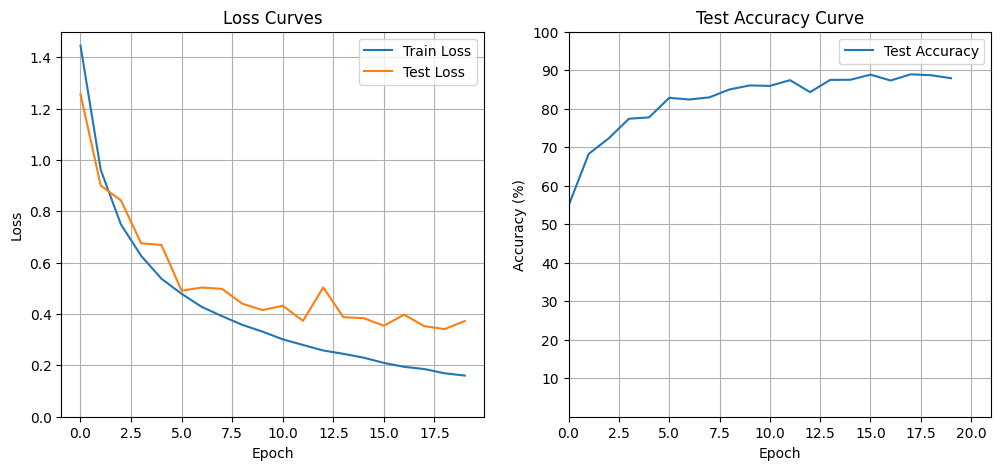

In [11]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_ad, label='Train Loss')
plt.plot(test_losses_ad, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,1.5)
plt.grid(True)
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(test_accuracies_ad, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.ylim(0,100)
plt.xlim(0,21)
plt.yticks([10,20,30,40,50,60,70,80,90,100])
plt.grid(True)
plt.legend()
plt.title('Test Accuracy Curve')
plt.show()

### Cosine Annealing

In [13]:
from torch.optim.lr_scheduler import CosineAnnealingLR

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet18(num_classes=10).to(device)
# Define the optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Starting learning rate
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

num_epochs = 20
train_losses_ca, test_losses_ca, test_accuracies_ca = [], [], []

# Training Loop
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
    
    # Update learning rate using the scheduler
    scheduler.step()

    # Store losses and accuracy
    train_losses_ca.append(train_loss)
    test_losses_ca.append(test_loss)
    test_accuracies_ca.append(test_accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Epoch [1/20], Train Loss: 1.4677, Test Loss: 1.2946, Test Accuracy: 55.27%
Epoch [2/20], Train Loss: 0.9748, Test Loss: 0.9283, Test Accuracy: 67.36%
Epoch [3/20], Train Loss: 0.7644, Test Loss: 0.8338, Test Accuracy: 71.01%
Epoch [4/20], Train Loss: 0.6305, Test Loss: 0.6770, Test Accuracy: 76.69%
Epoch [5/20], Train Loss: 0.5381, Test Loss: 0.6012, Test Accuracy: 78.97%
Epoch [6/20], Train Loss: 0.4764, Test Loss: 0.4980, Test Accuracy: 83.24%
Epoch [7/20], Train Loss: 0.4249, Test Loss: 0.4784, Test Accuracy: 83.33%
Epoch [8/20], Train Loss: 0.3725, Test Loss: 0.4740, Test Accuracy: 83.64%
Epoch [9/20], Train Loss: 0.3374, Test Loss: 0.3930, Test Accuracy: 86.29%
Epoch [10/20], Train Loss: 0.3004, Test Loss: 0.3932, Test Accuracy: 86.57%
Epoch [11/20], Train Loss: 0.2640, Test Loss: 0.3518, Test Accuracy: 88.02%
Epoch [12/20], Train Loss: 0.2325, Test Loss: 0.3607, Test Accuracy: 87.67%
Epoch [13/20], Train Loss: 0.1982, Test Loss: 0.3416, Test Accuracy: 88.70%
Epoch [14/20], Train 

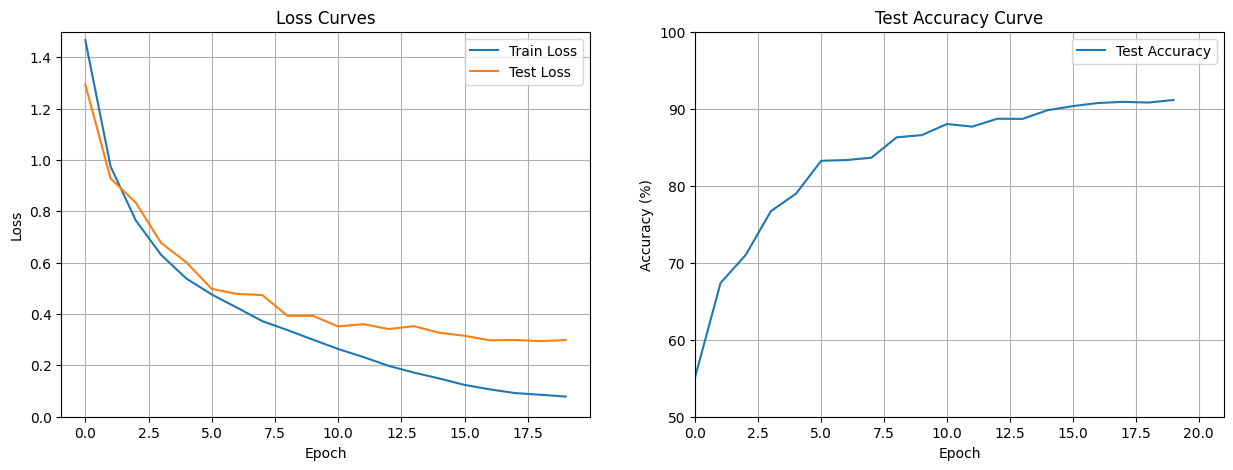

91.13


In [14]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_ca, label='Train Loss')
plt.plot(test_losses_ca, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,1.5)
plt.grid(True)
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(test_accuracies_ca, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.ylim(50,100)
plt.xlim(0,21)
plt.yticks([50,60,70,80,90,100])
plt.grid(True)
plt.legend()
plt.title('Test Accuracy Curve')
plt.show()

print(max(test_accuracies_ca))